In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

In [ ]:
from torchvision import datasets, transforms
from torchvision.transforms import v2

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
train_dataset = datasets.MNIST(
    root = './mnist',
    train=True,
    download=True,)

test_dataset = datasets.MNIST(
    root = './mnist',
    train=False,
    download=True,)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 3.53MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 154kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.49MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.22MB/s]


In [ ]:
print(f"학습 데이터 개수: {len(train_dataset)}")
print(f"테스트 데이터 개수: {len(test_dataset)}")

학습 데이터 개수: 60000
테스트 데이터 개수: 10000


In [ ]:
train_dataset.__getitem__(0)[0]

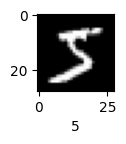

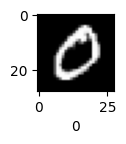

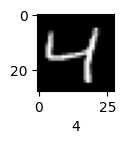

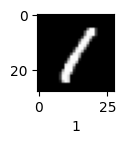

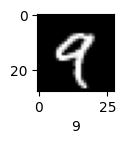

In [ ]:
def visualize_data(image, label):
    class_names = range(10)
    plt.figure(figsize = (1,1))
    plt.imshow(image, cmap='gray')
    plt.xlabel(class_names[label])
    plt.show()

for i in range(5):
    image, label = train_dataset.__getitem__(i)[0], train_dataset.__getitem__(i)[1]

    visualize_data(image, label)

In [ ]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]
)  # augmentation, 전처리 (resize, ..), data type (tensor,..)

In [ ]:
train_dataset = datasets.MNIST(
    root = './mnist',
    train=True,
    download=True,
    transform = transforms,

)

test_dataset = datasets.MNIST(
    root = './mnist',
    train=False,
    download=True,
    transform = transforms,
)

In [ ]:
image, label = train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
# image

In [ ]:
# label

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 128)

In [ ]:
[128, 1, 28, 28]

In [ ]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 → 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 14x14 → 7x7
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 → 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14x14 → 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = MyAutoEncoder()

In [ ]:
model = CNNAutoencoder()

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [ ]:
for image, label in train_dataloader:
    print(image.shape)
    break

torch.Size([128, 1, 28, 28])


In [ ]:
model(image.to(device)).shape

torch.Size([128, 1, 28, 28])

In [ ]:
image.view(image.size(0), -1).shape

torch.Size([128, 784])

In [ ]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image, label in train_dataloader:
        image = image.view(image.size(0), -1).to(device)
        pred = model(image)
        loss = loss_fn(pred, image)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch}/{epochs}, Loss : {total_loss/len(train_dataloader)}")

In [ ]:
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.view(image.size(0), -1).to(device)
        pred = model(image)
        break

In [ ]:
pred.shape # -> [128, 1, 28, 28]

torch.Size([128, 784])

In [ ]:
pred.view(-1, 28, 28).shape

torch.Size([128, 28, 28])

In [ ]:
image.view(-1, 28, 28).shape

torch.Size([128, 28, 28])

In [ ]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)

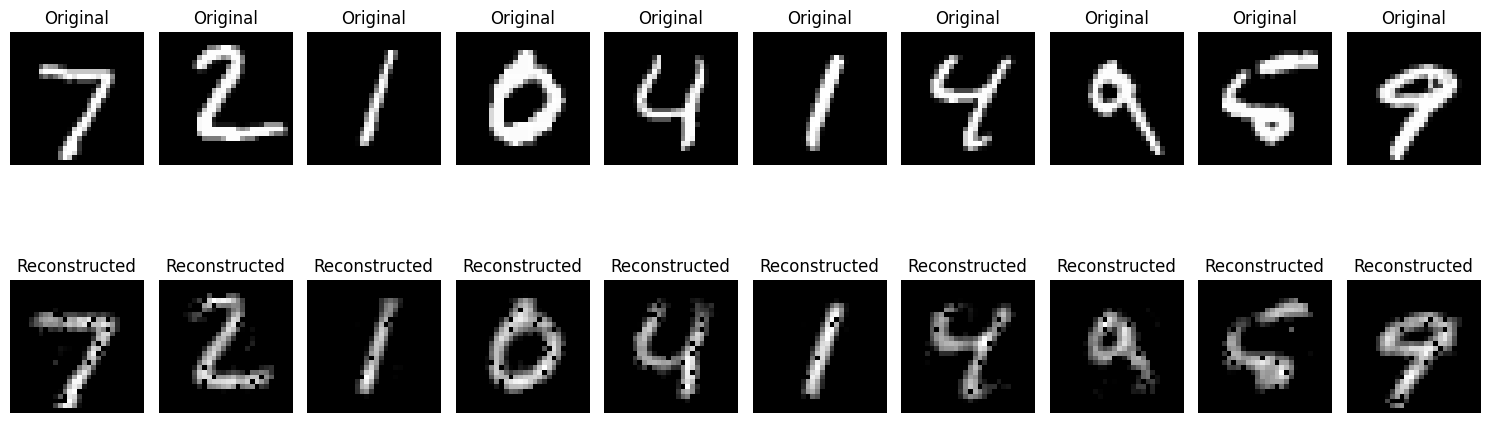

In [ ]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)
fig, axes = plt.subplots(2, 10, figsize = (15, 6))

for i in range(10):
    axes[0, i].imshow(image[i].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(pred[i].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# representation z 를 잘 학습했다. -> 원본 이미지의 특징을 잘 파악했다.

In [ ]:
class MyAutoEncoder_vis(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    def encode(self, x):
        return self.encoder(x)

In [ ]:
model = MyAutoEncoder_vis()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
model.to(device)

MyAutoEncoder_vis(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): ReLU()
  )
)

In [ ]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image, label in train_dataloader:
        image = image.view(image.size(0), -1).to(device)
        pred = model(image)
        loss = loss_fn(pred, image)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch}/{epochs}, Loss : {total_loss/len(train_dataloader)}")

Epoch 0/10, Loss : 0.08398995531012
Epoch 1/10, Loss : 0.07079590572667782
Epoch 2/10, Loss : 0.06749548477881244
Epoch 3/10, Loss : 0.06510514931193292
Epoch 4/10, Loss : 0.0618664431753062
Epoch 5/10, Loss : 0.05851983899341972
Epoch 6/10, Loss : 0.05639673932306548
Epoch 7/10, Loss : 0.05491733091122814
Epoch 8/10, Loss : 0.05316883911773848
Epoch 9/10, Loss : 0.05195289320433572


In [ ]:
all_latents = []
all_labels = []

model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.view(image.size(0), -1).to(device)
        latent = model.encode(image)
        pred = model(image)
        all_latents.append(latent.cpu().numpy())
        all_labels.append(label.cpu().numpy())


In [ ]:
len(all_labels)

79

In [ ]:
pred.shape, image.shape

(torch.Size([16, 784]), torch.Size([16, 784]))

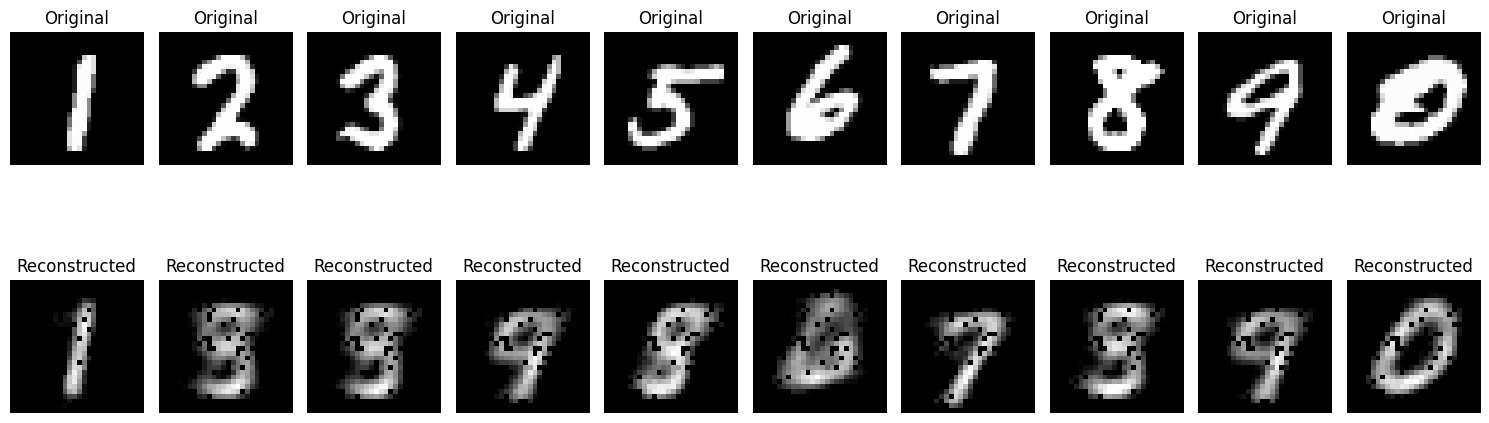

In [ ]:
pred = pred.view(-1, 28, 28)
image = image.view(-1, 28, 28)
fig, axes = plt.subplots(2, 10, figsize = (15, 6))

for i in range(10):
    axes[0, i].imshow(image[i].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(pred[i].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
all_latents[0][:,0]

array([-4.123783  ,  3.168201  , -3.1456008 ,  7.3857913 , -0.5168403 ,
       -4.6573496 , -1.0857884 ,  0.7824939 ,  0.22186221, -6.007775  ,
        7.892335  ,  3.541126  , -2.1971924 ,  5.9161806 , -3.8819938 ,
        2.320331  , -1.2013363 , -3.2380648 ,  2.0369549 , -0.47766364,
       -5.0930014 ,  2.7657177 ,  1.9392674 ,  0.799216  , -0.27837217,
       13.657755  , -0.501329  , -0.73538303,  6.0985804 , -1.6810505 ,
        1.2199566 , -1.181077  ,  1.3258423 ,  5.718323  , -4.8314476 ,
        3.862092  , -1.2765155 , -3.0513387 ,  2.9782152 , -5.0408335 ,
       -2.0598426 , -1.733883  , -1.1257725 ,  1.2150251 ,  1.775248  ,
        1.8606651 ,  0.81810445,  2.5139143 , -1.4665704 , -0.18131605,
        2.9365451 ,  2.3392277 ,  0.58510983,  1.7083138 ,  5.4305935 ,
        3.8005362 , -0.44548965, -3.573169  , -1.42328   , -1.7908586 ,
        0.20462546,  2.2813313 , -0.07983319,  2.0908806 , -4.278     ,
        0.11191253,  3.0376341 , -1.0433393 ,  1.397675  , 10.30

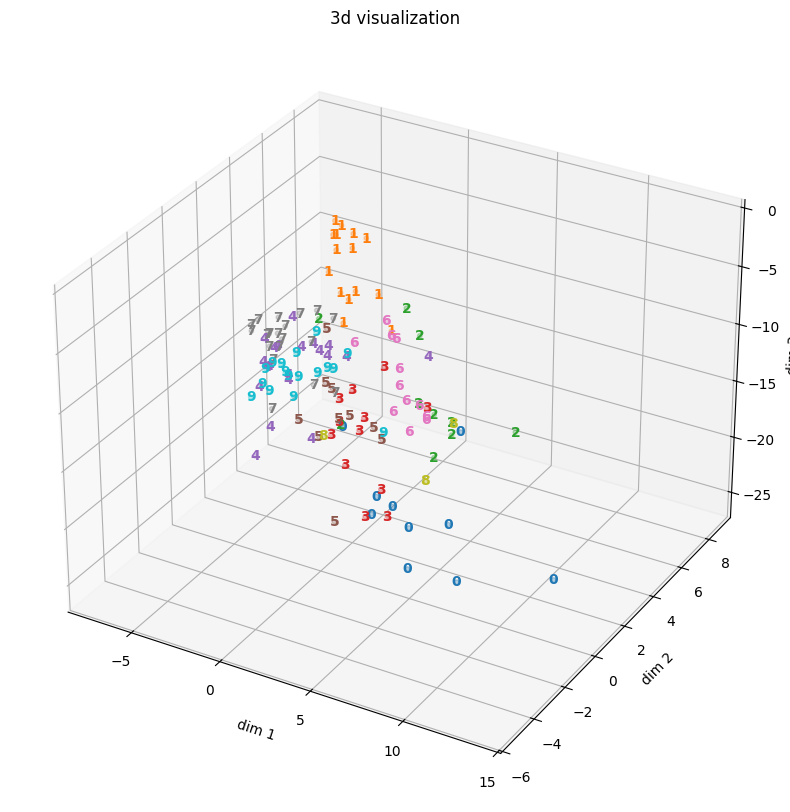

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(all_latents[0][:,0], all_latents[0][:,1], all_latents[0][:,2], c=all_labels[0], cmap='tab10', s=10, alpha=0.3)

for digit in range(10):
    indices = np.where(all_labels[0] == digit)[0]
    sample_indices = np.random.choice(indices, size=min(50, len(indices)), replace=False)

    for idx in sample_indices:
        x, y, z = all_latents[0][idx, 0], all_latents[0][idx, 1], all_latents[0][idx, 2]
        ax.text(x, y, z, str(digit), color=plt.cm.tab10(digit), fontsize=10, fontweight='bold', ha='center', va='center')

ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")
ax.set_zlabel("dim 3")
plt.title("3d visualization")
plt.show()